In [19]:
#import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=25,10
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('D:\Simplilearn Goal\Machine Learning course\Practise projects\Lesson 8-Time Series Modeling')

In [12]:
df=pd.read_csv('zinc_prices_IMF.csv')

In [13]:
df=df.set_index('Date')
df

,Price
Date,
1-Jan-80,773.82
1-Feb-80,868.62
1-Mar-80,740.75
1-Apr-80,707.68
1-May-80,701.07
...,...
1-Oct-15,1724.34
1-Nov-15,1583.31
1-Dec-15,1527.79


In [14]:
ts=df['Price']
ts_log=np.log(ts)

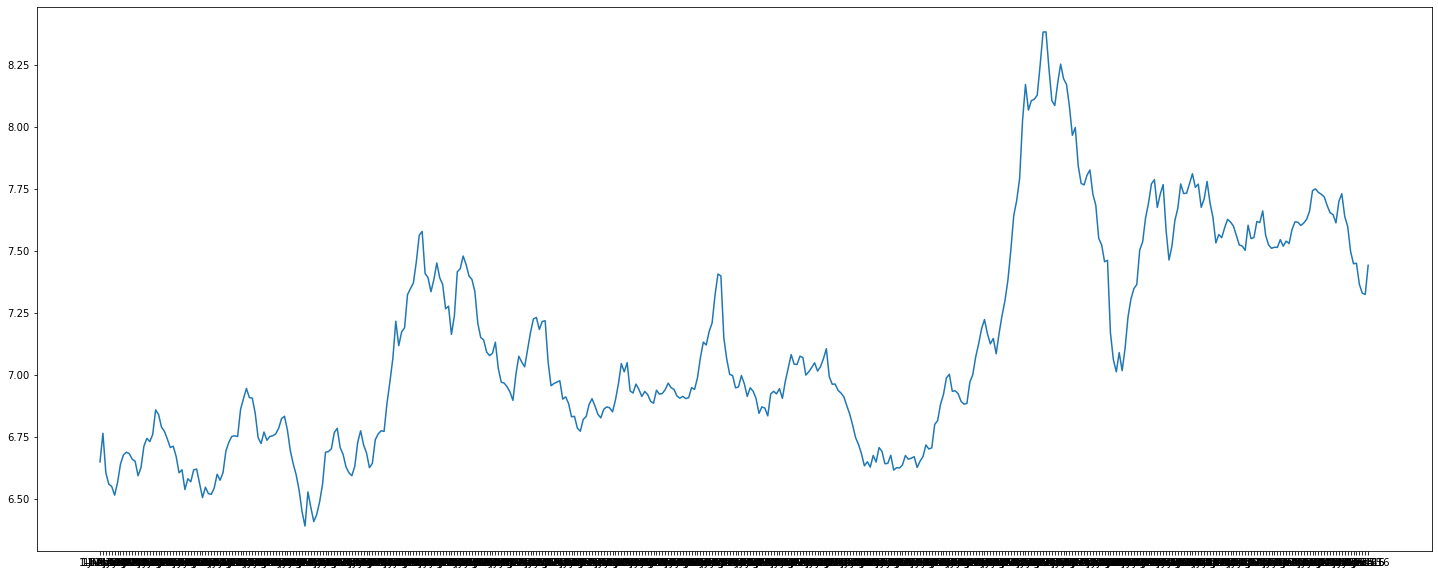

In [20]:
plt.plot(ts_log)

In [22]:
def test_stationary(timeseries):
    rollmean=timeseries.rolling(window=52,center=False).mean()
    rollstd=timeseries.rolling(window=52,center=False).std()
    org=plt.plot(timeseries,color='blue',label='orginal')
    mean=plt.plot(rollmean,color='red',label='mean')
    std=plt.plot(rollstd,color='black',label='std')
    plt.legend()
    plt.show()
    
    print(' Dicker full test result:')
    df_test=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(df_test[0:4],index=['Text Statistic','p-value','#Lags used','Number of Observations used'])
    
    for key,value in df_test[4].items():
        dfoutput['critical value (%s)'%key]=value
    print(dfoutput)

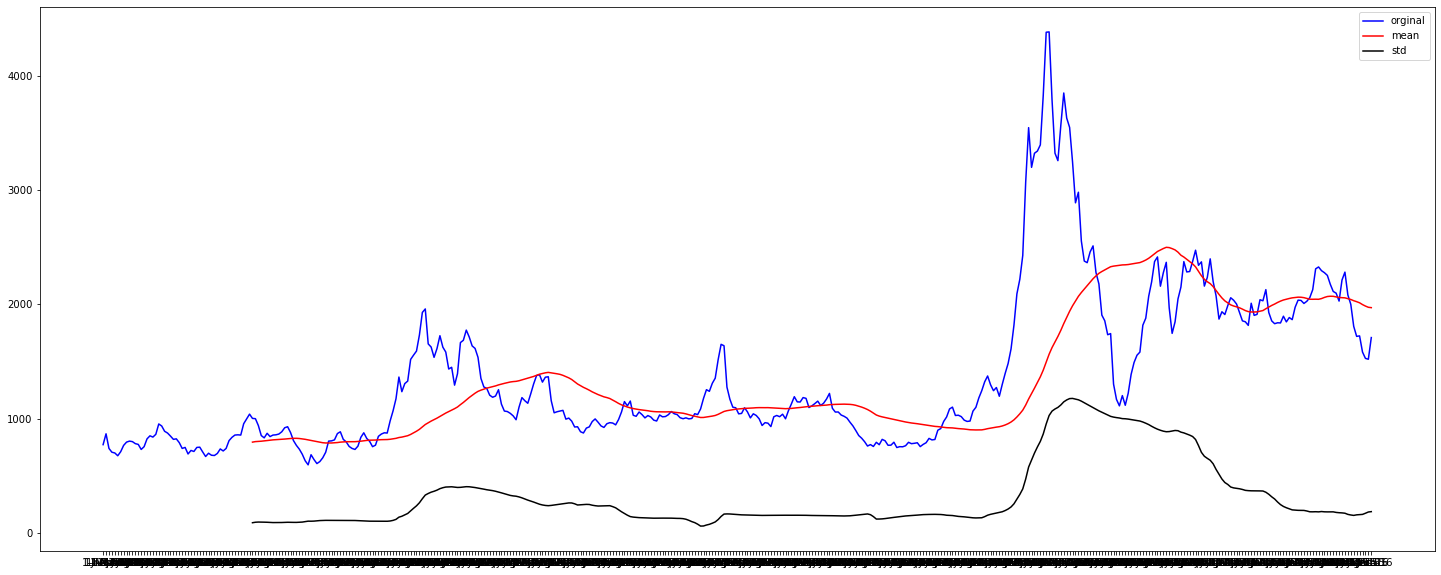

 Dicker full test result:
Text Statistic                  -3.139601
p-value                          0.023758
#Lags used                       7.000000
Number of Observations used    426.000000
critical value (1%)             -3.445794
critical value (5%)             -2.868349
critical value (10%)            -2.570397
dtype: float64


In [23]:
test_stationary(ts)

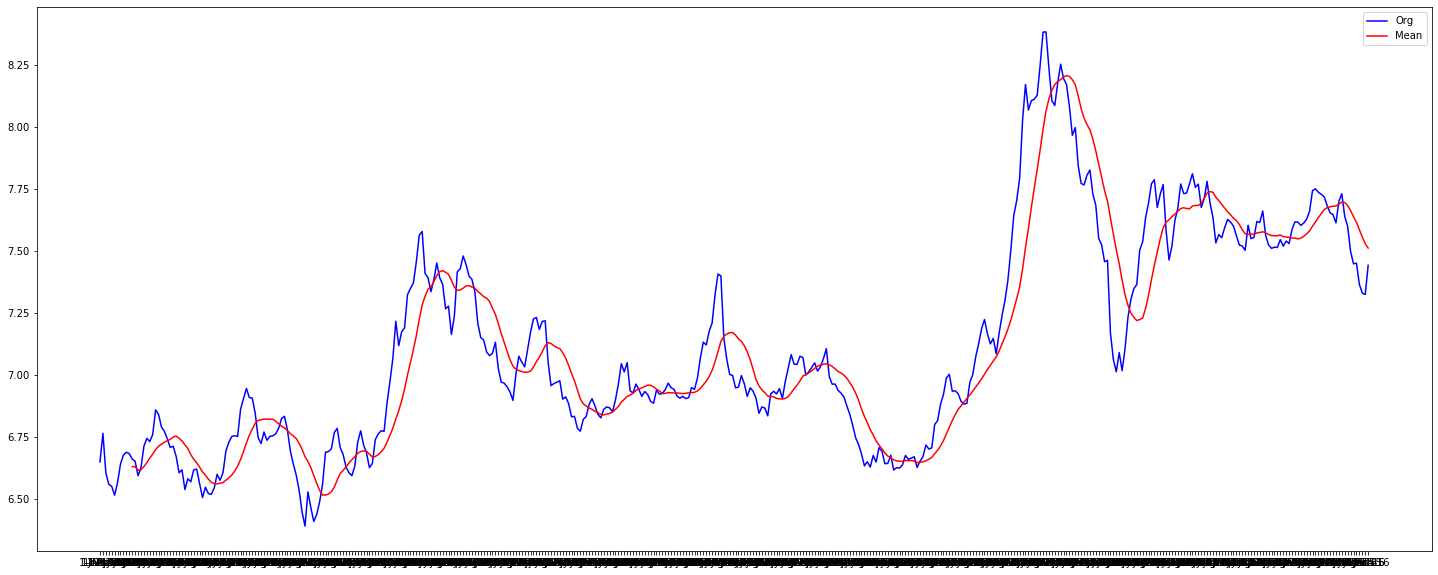

In [24]:
MoveAverage=ts_log.rolling(window=12,center=False).mean()
MoveStd=ts_log.rolling(window=12,center=False).std()
org=plt.plot(ts_log,color='Blue',label='Org')
Mean=plt.plot(MoveAverage,color='Red',label='Mean')
plt.legend()
plt.show()

In [25]:
ts_log_mv_diff=ts_log-MoveAverage
ts_log_mv_diff.head()
ts_log_mv_diff.dropna(inplace=True)

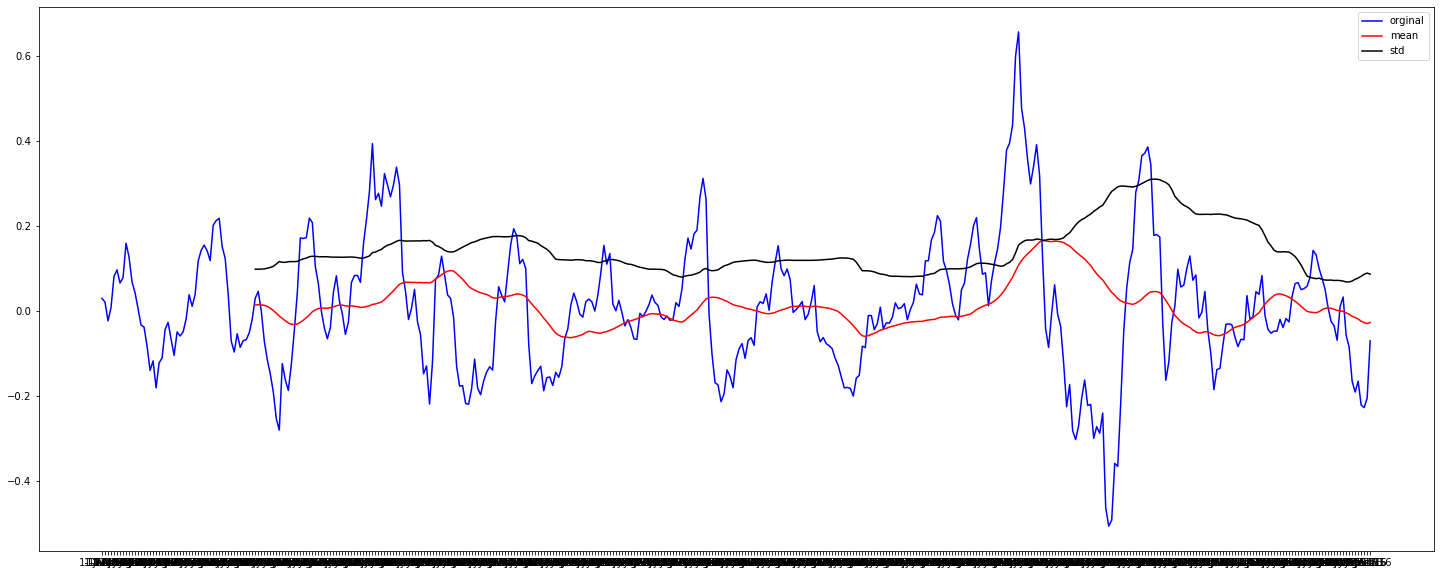

 Dicker full test result:
Text Statistic                -5.898484e+00
p-value                        2.814411e-07
#Lags used                     4.000000e+00
Number of Observations used    4.180000e+02
critical value (1%)           -3.446091e+00
critical value (5%)           -2.868479e+00
critical value (10%)          -2.570466e+00
dtype: float64


In [26]:
test_stationary(ts_log_mv_diff)

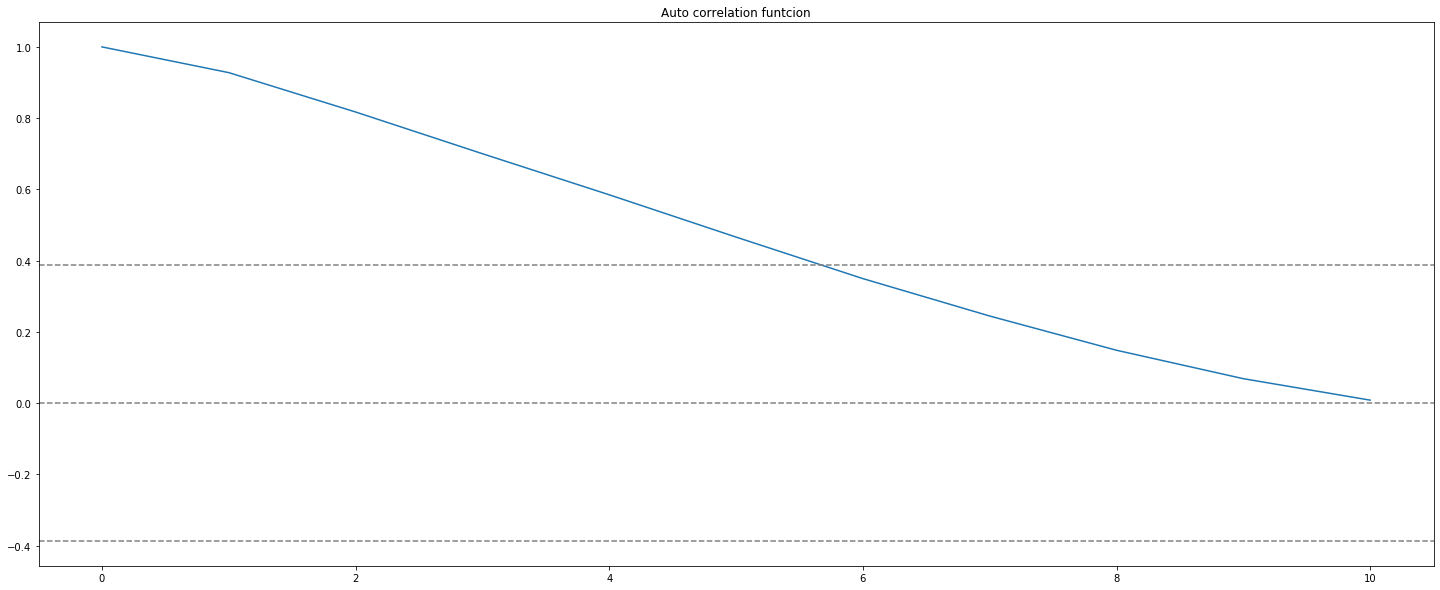

In [27]:
#Ploting acf graph
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title('Auto correlation funtcion')
plt.show()

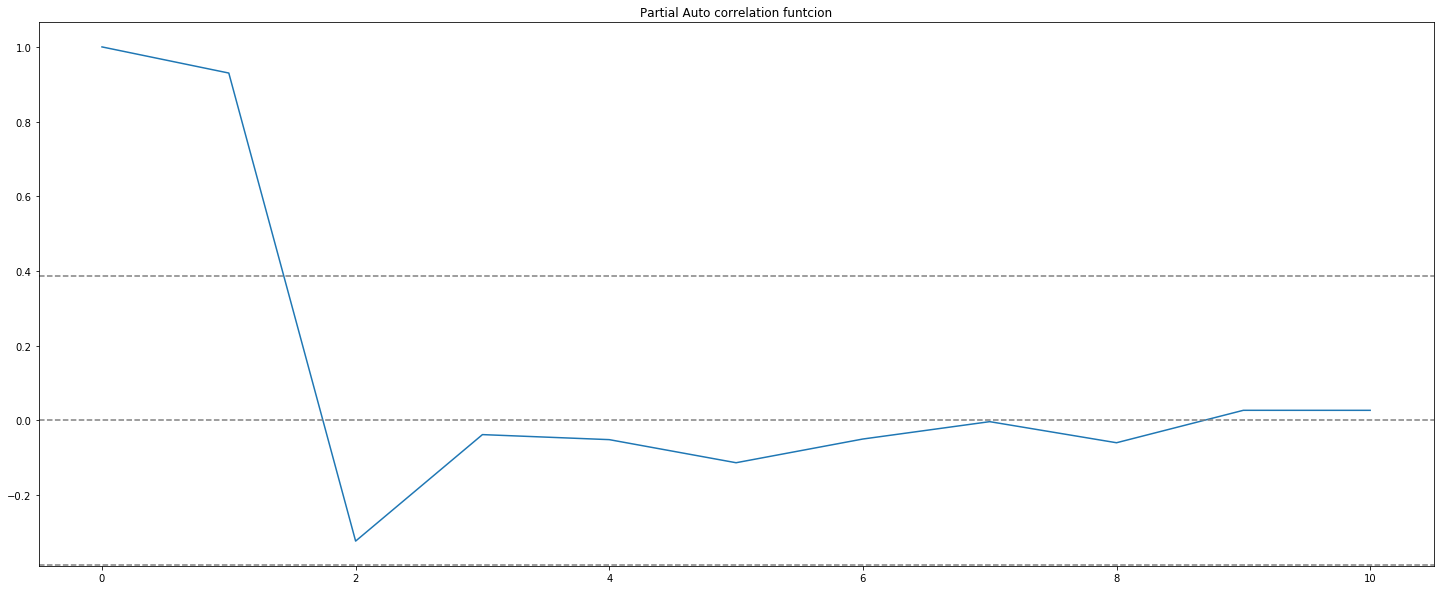

In [36]:
#Ploting pacf graph
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title('Partial Auto correlation funtcion')
plt.show()

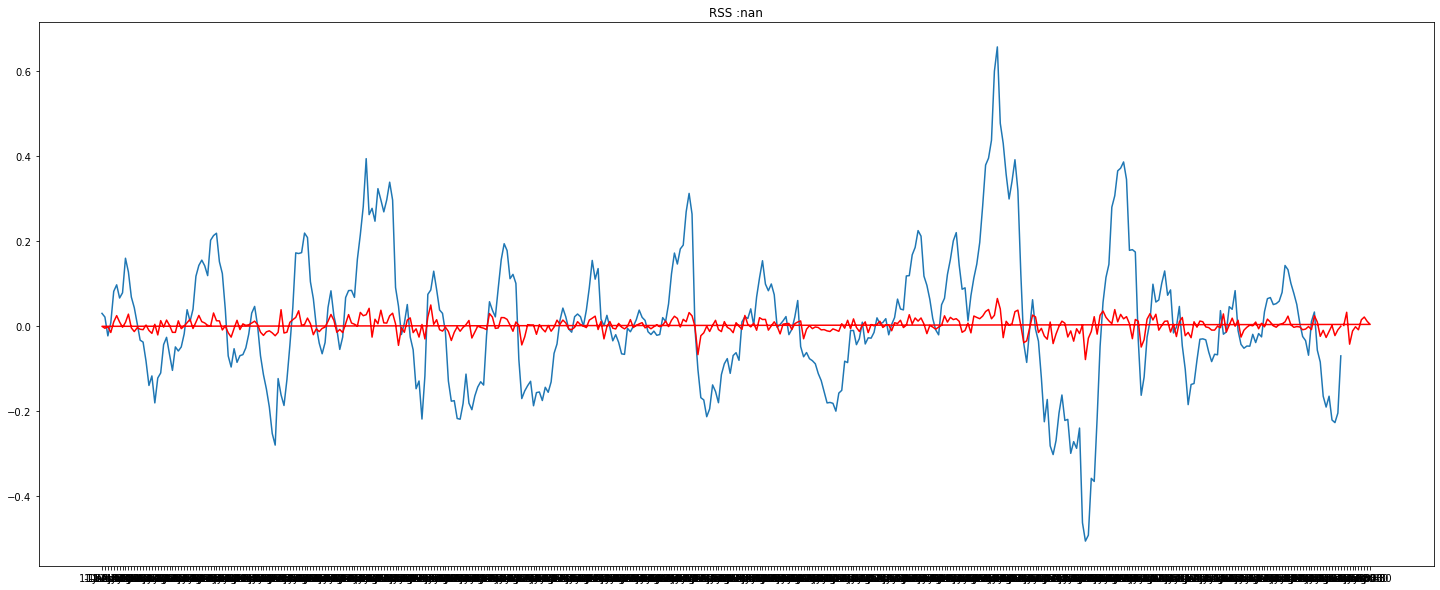

In [29]:
model=ARIMA(ts_log,order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS :%.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))
plt.show()

In [30]:
#model predictions
pred_arima_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
pred_arima_diff.head()

Date
1-Feb-80    0.002030
1-Mar-80    0.033049
1-Apr-80   -0.042031
1-May-80   -0.011002
1-Jun-80   -0.001089
dtype: float64

In [31]:
pred_arima_diff_cum_sum=pred_arima_diff.cumsum()
pred_arima_diff_cum_sum.head()

Date
1-Feb-80    0.002030
1-Mar-80    0.035079
1-Apr-80   -0.006952
1-May-80   -0.017955
1-Jun-80   -0.019043
dtype: float64

In [33]:
pred_Arima_log=pd.Series(ts_log.ix[0],index=ts_log.index)
pred_Arima_log=pred_Arima_log.add(pred_arima_diff_cum_sum,fill_value=0)
pred_Arima_log.head()

Date
1-Apr-00    7.109676
1-Apr-01    7.099661
1-Apr-02    7.061614
1-Apr-03    7.069248
1-Apr-04    7.177724
dtype: float64

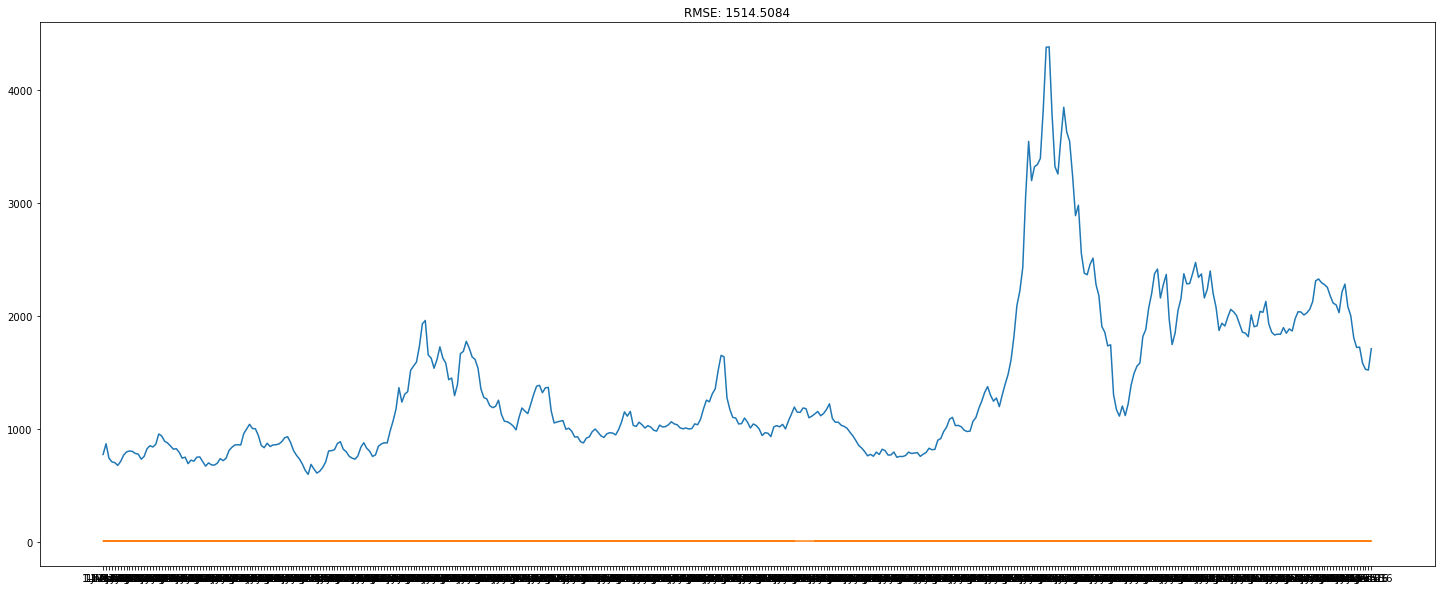

In [35]:
#### predictions_ARIMA=np.exp(pred_Arima_log)
plt.plot(ts)
plt.plot(pred_Arima_log)
plt.title('RMSE: %.4f'%np.sqrt(sum((pred_Arima_log-ts)**2)/len(ts)))
plt.show()